# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/study/Github/MLDL1/Lab

/content/drive/MyDrive/study/Github/MLDL1/Lab


In [3]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.11.0+cu113, Device: cuda


# Utils

In [2]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# Load Data: CIFAR-10

In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [26]:
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir="./CIFAR_10"):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, data):
        #### TODO ####
        batch_x, batch_y = [], []
        for x, y in data:
          if self.transform is not None:
            x = self.transform(x)
          x = transforms.ToTensor()(x)
          y = torch.Tensor([y])
          batch_x.append(x)
          batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()
        return batch_x, batch_y
        ##############

In [27]:
## Load CIFAR-10 Dataset

train_dataset = CustomDataset(train = True)
test_dataset = CustomDataset(train = False)

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [9]:
for X_train, y_train in train_dataset:
    print('X_train:', X_train, 'type:', type(X_train))
    print('y_train:', y_train, 'type:', type(y_train))
    break

X_train: <PIL.Image.Image image mode=RGB size=32x32 at 0x7FB07A1D7190> type: <class 'PIL.Image.Image'>
y_train: 6 type: <class 'int'>


In [10]:
print(len(train_loader), len(test_loader))
print(len(train_dataset) / 32, len(test_dataset) / 32)

1563 313
1562.5 312.5


In [28]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [14]:
x = np.array(train_dataset[0][0])
print(x.shape)
print(transforms.ToTensor()(x).shape)

(32, 32, 3)
torch.Size([3, 32, 32])


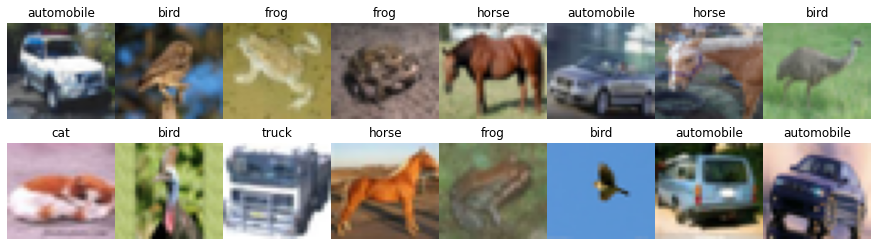

In [15]:
plot_dataset(train_loader)

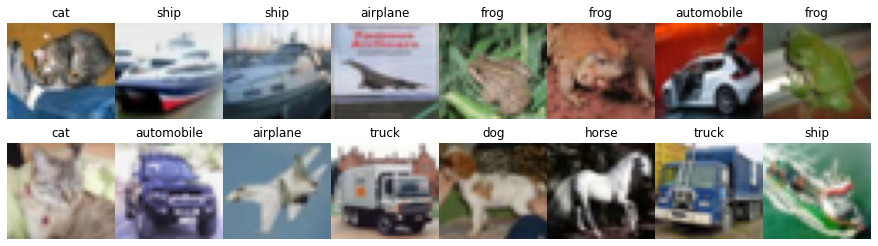

In [16]:
plot_dataset(test_loader)

# Multi-layer Perceptron

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim = 1)
        return x

In [ ]:
model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

In [20]:
def train(model, train_loader, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step() # lr scheduler decays the learning rate every epoch
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

In [21]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MLP, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

# Convolutional Neural Networks

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(6 * 6 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 6 * 6 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.softmax(x)
        return x

In [22]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [29]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	Test Loss: 0.0472, 	Test Accuracy: 44.67 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	Test Loss: 0.0439, 	Test Accuracy: 48.85 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	Test Loss: 0.0404, 	Test Accuracy: 53.96 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	Test Loss: 0.0379, 	Test Accuracy: 56.59 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	Test Loss: 0.0386, 	Test Accuracy: 55.97 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: CNN, 	Test Loss: 0.0355, 	Test Accuracy: 60.05 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: CNN, 	Test Loss: 0.0355, 	Test Accuracy: 60.32 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: CNN, 	Test Loss: 0.0354, 	Test Accuracy: 60.91 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: CNN, 	Test Loss: 0.0344, 	Test Accuracy: 61.58 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: CNN, 	Test Loss: 0.0341, 	Test Accuracy: 62.58 % 



# Learning Rate Tuning Examples



In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(2 * 20, 4))
    plt.subplot(1, 6, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 6, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
## adjust the learning rate and observe what happens

LR = 0.001

EPOCHS = 5
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MNIST NET, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    
plot_history(history)

# Architectural Search

In [ ]:
## Load CIFAR-10 Dataset

train_dataset = CustomDataset(train = True)
test_dataset = CustomDataset(train = False)

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = test_dataset.collate_fn)

In [ ]:
## see how the input shape changes after applying the layer

x = torch.randn(32, 3, 32, 32)
x = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)(x)
# x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
print(x.shape)

In [ ]:
## Define your own CNN model - try various kinds of model designs

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        #### TODO ####
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), # 1-dim squeeze
            nn.Linear(16*12*12, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        ##############
        
    def forward(self, x):
        #### TODO ####
        x = self.conv(x)
        ##############
        return x

In [ ]:
model = MyCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## add lr scheduler
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.9)

print(model)

In [ ]:
## Experiment how your CNN works and compare the results

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MY CNN, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, scheduler.get_last_lr()[0], test_loss, test_accuracy))


# Data Augmentation

In [ ]:
batch_x, batch_y = next(iter(train_loader))

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(batch_x[i], (1, 2, 0)))
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

In [ ]:
## PyTorch data augmentation - reference: https://pytorch.org/vision/master/transforms.html

augment = transforms.Grayscale(num_output_channels=3)
# augment = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
# augment = transforms.RandomHorizontalFlip(p=0.5)
# augment = transforms.RandomVerticalFlip(p=0.5)
# augment = transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(augment(batch_x[i]), (1, 2, 0)))
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

In [ ]:
augment_transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    # transforms.ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(train = True, transform = augment_transform)
test_dataset = CustomDataset(train = False, transform = augment_transform)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         collate_fn = test_dataset.collate_fn)

In [ ]:
plot_dataset(test_loader)

In [ ]:
for _ in range(len(test_loader)-1):
  next(iter(test_loader))

In [ ]:
plot_dataset(test_loader)

In [ ]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
## compare the training results with the model trained without data augmentation

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

# Easier way to load CIFAR-10 data with data augmentation

In [ ]:
transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root = "./CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transform)

test_dataset = datasets.CIFAR10(root = "./CIFAR_10",
                                train = False,
                                download = True,
                                transform = transform)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

In [ ]:
## dataset outputs randomly augmented image every time

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.transpose(train_dataset[0][0], (1,2,0)))
    plt.axis('off')